## train_UNET_Selina - Cell contours
In this notebook we train a UNET CNN from scratch.

This includes the following steps:

* load the datasets consitent of images and binary ground truth masks
* preprocess the images (zero center, normalize to range -1 to 1, convert to float32)
* setup the data generator to apply data augmentation to both the input image and the ground truth mask
* setup the callbacks to monitor the training progress
* train the model
* store the resulting model
* plot training diagnostics


In [1]:
import tensorflow as tf
# TODO: remove after tf2.0 migration
# handle tf API changes 1.x to 2.0
from packaging import version
if version.parse(tf.__version__) < version.parse('2.0'):
    opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))
else:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e) 

1 Physical GPUs, 1 Logical GPUs


In [2]:
## check if tf detected a GPU 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos if x.device_type == 'GPU']



print("GPU device id: ", tf.test.gpu_device_name())
print("GPU details: \n" , get_available_gpus())

GPU device id:  /device:GPU:0
GPU details: 
 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 119275520
locality {
  bus_id: 1
  links {
  }
}
incarnation: 565106964341660606
physical_device_desc: "device: 0, name: Quadro M4000, pci bus id: 0000:65:00.0, compute capability: 5.2"
]


### UNET Model

The UNET model was developed in 2015 by the University of Freibug for cell boundary segmentation (https://arxiv.org/abs/1505.04597) and has since been widely adopted for image segmenation tasks. One of it's main benefits is that it is end-to-end approach, the ouput of the network has the same dimensions as the input (width x height x N). This does not only make it easier to use the model, it also provides the model with a large set of negative samples even if only a few images are used. The paper describes succesfully training the model with only 20 images.

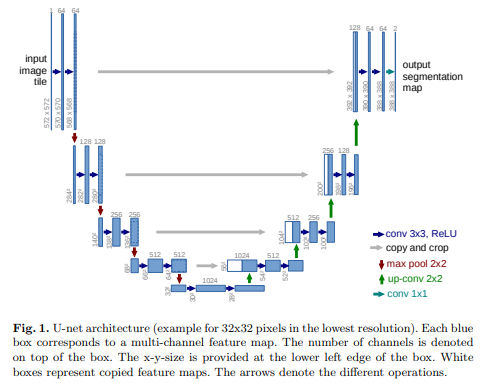

An implementation in Keras/Tensorflow is provided in UNETmodel.py.

In [3]:
## load the UNet model from UNETmodel.py
# details the the network can be found here: 
from includes.UNETmodel import UNet

# create model takes three arguments
#   the dimension of the input image (width x height x channels)
#   the number of classes 
#   the number of convolution kernels (default 32)

unet = UNet().create_model((720,540,1),1, d=8)

build UNet ...


In [4]:
# we can take a look at the network architecture by calling the summary function of the model
# using tensorboard we will get a more intuitive representation later on 
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 540, 1) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 720, 540, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 720, 540, 8)  584         conv1_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 360, 270, 8)  0           conv2d[0][0]                     
______________________________________________________________________________________________

The next step is to collect our training data. 

The UNET network ouputs the same dimensions [w x h] as provided as input.
Hence we provide the input images [ w x h x 1] and the corresponding binary masks [ w x h x 1]

A batch of images provided to the network always has the form [ N x w x h x c] 
where N is the number of samples, width, height and the number of channels. 
The number of channels is one for grayscale images or 3 for rgb, for binary calssification c is one in the ouptut.


Note that we normalise the images to be zero centered between -1 and 1 to be independent of variations in illumination.
Both input and output are converted to float32. The masks (which are equal to the ground truth) must be between 0 and 1 
due to the sigmoidal activation in the last layer of the network, hence the output can only be in the range between 0 and 1.

In [5]:
def preprocess(img):
    return (img - np.mean(img)) / np.std(img).astype(np.float32)

In [6]:
# MAIN PROCESSING LOOP
# load the training images and masks
import os
import imageio
import numpy as np
import clickpoints
from matplotlib.path import Path

# TODO do we export all images or just the ones with ellipsoids? might be good as negative samples?

search_path = '../results/cell_contours/train'
file_list = []
for root, dirs, files in os.walk(search_path):
    for file in files:
        if not file.endswith(".cdb"):
            continue
        file_list.append(os.path.abspath(os.path.join(root, file)))
print(file_list)

images = []
masks = []

num_cells = 0
images_total = 0
# For calculation of the mask
nx, ny = 540,720
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T
        
for cdb_file in file_list:
    cdb = clickpoints.DataFile(cdb_file)
    cdb_path = os.path.split(cdb_file)[0]

    # Get polygons of every image
    q_poly = cdb.getPolygons()
    img_ids = np.unique([pol.image.id for pol in q_poly])
    print("#%d found" % q_poly.count())
    
    
    # How many images in cdb
    q_img = cdb.getImages()
    ids = np.unique([el.sort_index for el in q_img])
    print("#%d images" % len(ids))
    images_total += len(ids)

    # Train just on image with polygons
    for id in img_ids:
        # get polygons in this image 
        img_o = cdb.getImage(id=id)
        polys = np.array([[e.points] for e in cdb.getPolygons(image=img_o)])
        img   = img_o.get_data()
        if len(img.shape) == 3:
            img = img[:,:,0]
        images.append(np.array(preprocess(img))[:,:,None])
        
        q_polys=cdb.getPolygons(image=img_o)
        
        mask = np.zeros((np.shape(img_o)[0:2]), dtype=np.uint8)
        for pol in q_polys:
            if np.shape(pol)[0] != 0:
                num_cells += 1
                polygon = np.array([[pol.points]])
                path = Path(polygon.squeeze())
                grid = path.contains_points(points)
                grid = grid.reshape((ny,nx))
                mask += grid
        masks.append(mask)
images = np.array(images)
masks = np.array(masks)[:,:,:,None]

print(images.shape)
print(masks.shape)

no openslide found
['/tf/results/cell_contours/train/gt_8_selina.cdb', '/tf/results/cell_contours/train/gt_7_selina.cdb', '/tf/results/cell_contours/train/gt_4_selina.cdb', '/tf/results/cell_contours/train/gt_5_richard.cdb', '/tf/results/cell_contours/train/gt_0_selina.cdb', '/tf/results/cell_contours/train/gt_3_selina.cdb', '/tf/results/cell_contours/train/gt_6_selina.cdb']
path /tf/results/cell_contours/train/gt_8_selina.cdb
Open database with version 22
#241 found
#500 images
path /tf/results/cell_contours/train/gt_7_selina.cdb
Open database with version 22
#310 found
#500 images
path /tf/results/cell_contours/train/gt_4_selina.cdb
Open database with version 22
#302 found
#500 images
path /tf/results/cell_contours/train/gt_5_richard.cdb
Open database with version 22
#411 found
#500 images
path /tf/results/cell_contours/train/gt_0_selina.cdb
Open database with version 22
#484 found
#500 images
path /tf/results/cell_contours/train/gt_3_selina.cdb
Open database with version 22
#416 fou

(-0.5, 539.5, 719.5, -0.5)

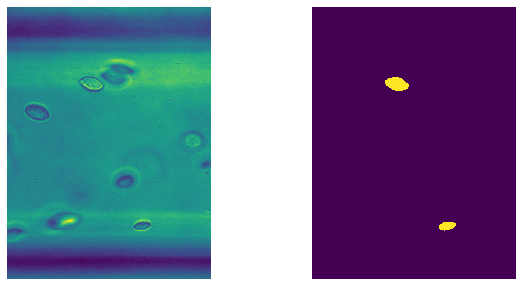

In [7]:
import matplotlib.pyplot as plt
id = 42

plt.figure(figsize=[10,5])
# show image
ax = plt.subplot(1,2,1)
plt.imshow(images[id].squeeze())
plt.axis('off')

# show calculated binary mask
ax = plt.subplot(1,2,2)
plt.imshow(masks[id].squeeze())
plt.axis('off')

# Statistics:

In [157]:
print('Number of cells: {}'.format(num_cells))
print('Cells in {} images'.format(np.shape(images)[0]))
print('Total number of images: {}'.format(images_total))
print('Total number of positives in training images: {}'.format(np.sum(masks)))
print('Total number of pixels in training images: {}'.format(np.shape(images)[0] * np.shape(images)[1] * np.shape(images)[2]))
print('Class imbalance: {}'.format(np.sum(masks) / (np.shape(images)[0] * np.shape(images)[1] * np.shape(images)[2]) ))

Number of cells: 2448
Cells in 1504 images
Total number of images: 3500
Total number of positives in training images: 3766986
Total number of pixels in training images: 584755200
Class imbalance: 0.0064419880319148935


## Training the network -- Augmentation and training setup

We use a data generator to add some additional variation to the training images and thereby virtually increase the number of training images.
Augmentations consist of vertical and horizontal flipping and slight sheer of the images.
These augmentations a applied to both the input image and the ground truth masks using two generators run with identical seed values.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## individual generators
datagen_img = ImageDataGenerator(zca_whitening=False,
                             samplewise_center=False,
                             samplewise_std_normalization=False,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.1)

datagen_mask = ImageDataGenerator(zca_whitening=False,
                             samplewise_center=False,
                             samplewise_std_normalization=False,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.1)

# wrapper for parallel augmentations, generator for image masks combos
def datagen_comb(gen_img,gen_mask, X, y, batch_size=128):

    seed = np.random.randint(100)

    # just make sure the seed is identical - so modifications are applied identical on both samples
    geni = gen_img.flow(X,np.ones(len(X)), seed=seed, batch_size=batch_size)
    genm = gen_mask.flow(y,np.ones(len(y)), seed=seed, batch_size=batch_size)

    while True:
        Xi,_ = geni.next()
        yi,_ = genm.next()
        yield Xi, yi

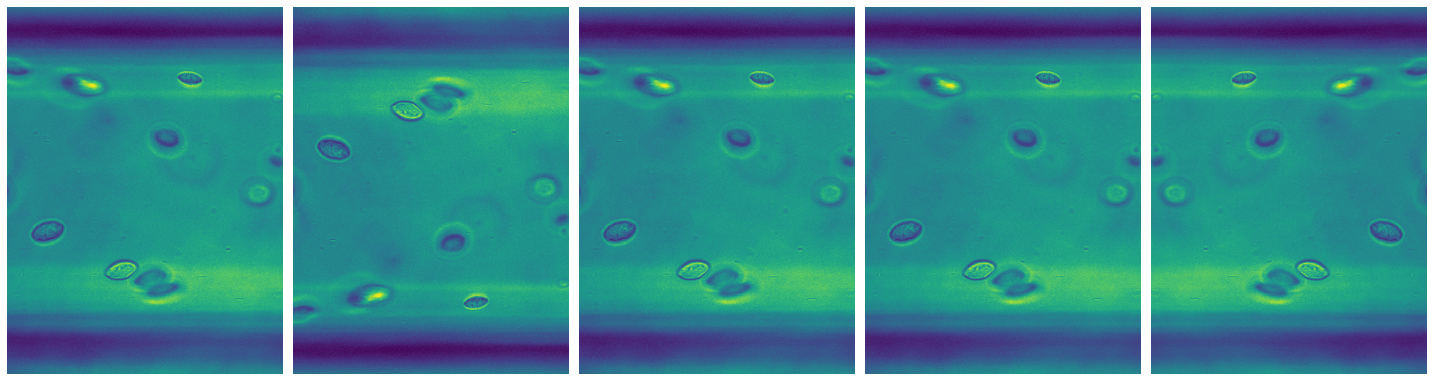

In [144]:
def plotImages(train_generator):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for ax in axes:
        ax.axis('off')
        x = next(train_generator)[0,:,:,0]
        ax.imshow(x)
    plt.tight_layout()
    #plt.savefig('/tf/results/results_new/' + 'augmentation.png')
    plt.show()
    
datagen_test = ImageDataGenerator(zca_whitening=False,
                             samplewise_center=False,
                             samplewise_std_normalization=False,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.1)

train_generator = datagen_test.flow(images[42][None,:,:,:])
x = next(train_generator)

plotImages(train_generator)

{'theta': 0, 'tx': 0, 'ty': 0, 'shear': -0.011327006393737987, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}
{'theta': 0, 'tx': 0, 'ty': 0, 'shear': -0.040331349281157586, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}
{'theta': 0, 'tx': 0, 'ty': 0, 'shear': -0.04876882104064102, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 1, 'channel_shift_intensity': None, 'brightness': None}
{'theta': 0, 'tx': 0, 'ty': 0, 'shear': -0.09367041180554299, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 1, 'channel_shift_intensity': None, 'brightness': None}


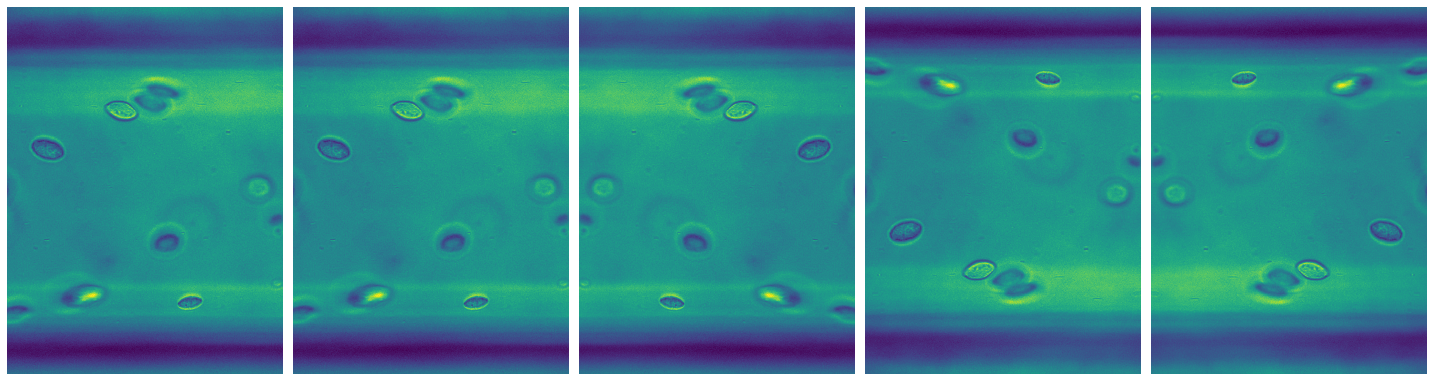

In [142]:
# Visualisation of image generator: test, what ranges seem acceptable
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
img = images[42][:,:,:]
img = img_to_array(img)
datagen = ImageDataGenerator()

fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
ax = axes[0]
ax.axis('off')
ax.imshow(images[42][:,:,0])
for ax in axes[1:]:
    ax.axis('off')
    transform = datagen_test.get_random_transform(images[42][None,:,:,:].shape)
    print(transform)
    x = datagen.apply_transform(x=img, transform_parameters=transform)
    ax.imshow(x[:,:,0])
    plt.tight_layout()
plt.savefig('/tf/results/results_new/' + 'augmentation.png')
plt.show()

In [8]:
#Training setup
from datetime import datetime
from focal_loss import BinaryFocalLoss

test_size = 0.2
random_state = 121
epochs = 100
batch_size = 4
learning_rate = 1e-3

loss = BinaryFocalLoss(gamma=2.)
#loss = 'binary_crossentropy'

metrics = ['accuracy']

stats = dict(
    name="Unet",
    version="0-0-5_fl_RAdam",
    date=datetime.now().strftime('%Y%m%d-%H%M%S'),
    data_raw="-".join(["gt_0","gt_3","gt_4","gt_5","gt_6","gt_7","gt_8"]),
    data_split="%d-%d"%(test_size*100, random_state),
    model_path="/tf/results/models/",
    model_ext="h5",
    log_path="/tf/results/logs/",
    img_path="/tf/results/singlePredictions/"
)

In [12]:
# generate test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=test_size, random_state=random_state)
print(np.shape(X_train), np.shape(X_test))

(1203, 720, 540, 1) (301, 720, 540, 1)


A custom callback allows us to visualize the effect of training iterations on the network.

This is not important - feel free to ignore it 

In [9]:
import os
from tensorflow.keras.callbacks import Callback

class SinglePredictionImage(Callback):
    def __init__(self, image, save_path, label=None, split_shape=None, verbose=0, batch_size=None, normalize=False):
        """
        :param image:
        the single image to predict on
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(SinglePredictionImage, self).__init__()

        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size
        self.savepath = save_path
        self.split_shape = split_shape
        self.image = image
        self.normalize = normalize
        os.makedirs(os.path.split(save_path)[0], exist_ok=True)
        imageio.imwrite(self.savepath.format(epoch="input"), (image*255).squeeze().astype(np.uint8))
        if label is not None:
            imageio.imwrite(self.savepath.format(epoch="mask"), (label*255).squeeze().astype(np.uint8))


    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        self.epoch.append(epoch)

        if self.split_shape is not None:
            out = np.array([self.model.predict(img[None,:])[0] for img in self.image])
            out = np.hstack(np.hstack(out.reshape((self.split_shape[0], self.split_shape[1], *self.image[0].shape[:2]))))
        else:
            out = self.model.predict(self.image[None,:])

        if self.normalize:
            out = (out-np.amin(out))/(np.amax(out)-np.amin(out))
        imageio.imwrite(self.savepath.format(epoch=epoch), (out*255).squeeze().astype(np.uint8))

Callbacks provide the means to do additional things at the end of an epoche (one itteration over the training data set).

Commonly used callbacks are

* tensorboard - which allows to display training progress in the tensorboard gui 
* checkpoint - which automatically stores the new model weights if the validation accuracy increases
* learning rate - decrease the learning rate for later epochs 
* custom checkpoint - like out singleprediction checkpoint 

In [10]:
# Prepare callbacks
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler,ReduceLROnPlateau

# create output paths 
filepath = "{model_path}{name}_{version}_{date}.{model_ext}".format(**stats)
img_path = "{img_path}/{name}_{version}/{epoch}.jpg".format(epoch="{epoch}",**stats)
log_dir = '{log_path}{name}_{version}_{date}'.format(**stats)
print("Logs:")
print(filepath)
print(log_dir)


tensorboard = TensorBoard(log_dir=log_dir,
                          histogram_freq=0, write_graph=True, write_images=False)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy', save_best_only=False)

# Not tested with this callback yet
cbTensorboard = tf.keras.callbacks.TensorBoard(log_dir='/tf/results/logs/'+model_ts, profile_batch=0)

def scheduler(epoch):
  learning_rate = 1e-5
  if epoch < 10:
    return learning_rate
  if epoch < 20:
    return learning_rate * 0.1
  if epoch < 40:
    return learning_rate * 0.01
  if epoch >= 40:
    return learning_rate * 0.001

learningrate = LearningRateScheduler(scheduler)

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

#stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, restore_best_weights=True)

singleprediction = SinglePredictionImage(images[10], img_path, label=masks[10])

callbacks = [checkpoint, tensorboard, singleprediction]
#TODO: insert cbTensorboard into callbacks

Logs:
/tf/results/models/Unet_0-0-5_fl_RAdam_20200724-154011.h5
/tf/results/logs/Unet_0-0-5_fl_RAdam_20200724-154011


NameError: name 'images' is not defined

In [15]:
# if TFA is not installed run 
#!pip install tensorflow_addons==0.6.0

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import RectifiedAdam

# TRAIN MODEL
#unet.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=metrics)
unet.compile(optimizer=RectifiedAdam(lr=learning_rate), loss=loss, metrics=metrics)

gen = datagen_comb(datagen_img, datagen_mask,
                   X_train , y_train,
                   batch_size = batch_size)

# train with generator and augmentation
history = unet.fit_generator(gen,
                             validation_data=(X_test, y_test),
                             epochs=epochs,
                             steps_per_epoch=X_train.shape[0] // batch_size,
                             class_weight=[0.01, 0.99],
                             callbacks=callbacks)

Epoch 1/100
300/300 [==============================] - 225s 750ms/step - loss: 0.0269 - accuracy: 0.9900 - val_loss: 0.0081 - val_accuracy: 0.9944
Epoch 2/100
300/300 [==============================] - 220s 735ms/step - loss: 0.0074 - accuracy: 0.9939 - val_loss: 0.0067 - val_accuracy: 0.9953
Epoch 3/100
300/300 [==============================] - 214s 713ms/step - loss: 0.0064 - accuracy: 0.9953 - val_loss: 0.0075 - val_accuracy: 0.9935
Epoch 4/100
300/300 [==============================] - 214s 713ms/step - loss: 0.0060 - accuracy: 0.9956 - val_loss: 0.0053 - val_accuracy: 0.9974
Epoch 5/100
300/300 [==============================] - 214s 715ms/step - loss: 0.0056 - accuracy: 0.9956 - val_loss: 0.0067 - val_accuracy: 0.9943
Epoch 6/100
300/300 [==============================] - 214s 713ms/step - loss: 0.0052 - accuracy: 0.9960 - val_loss: 0.0045 - val_accuracy: 0.9968
Epoch 7/100
300/300 [==============================] - 214s 712ms/step - loss: 0.0049 - accuracy: 0.9959 - val_loss: 0

In [1]:
import time

id = 1
batch_size = 10

with tf.device('/cpu:0'):
    t1 = time.perf_counter()
    prediction=unet.predict(X_test[id:id+batch_size])
    print("CPU elapsed:\t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size))
    
with tf.device('/gpu:0'):
    t1 = time.perf_counter()
    prediction=unet.predict(X_test[id:id+batch_size])
    print("GPU elapsed:\t%.2fs for a batch of %d images" % (time.perf_counter()- t1, batch_size))   


NameError: name 'tf' is not defined

GPU elapsed:	0.07s for a batch of 1 images


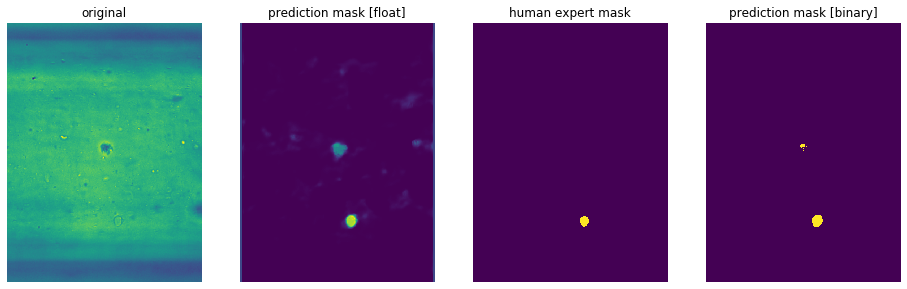

In [18]:
id = 13 # feel free to play with the id to change sample numpers 

t1 = time.perf_counter()
prediction=unet.predict(X_test[id:id+1])
print("GPU elapsed:\t%.2fs for a batch of %d images" % (time.perf_counter()- t1, 1))  

import matplotlib.pyplot as plt
pred = prediction[0]
fig, axes = plt.subplots(1,4,figsize=[16,5],)
ax=axes[0]
ax.set_title("original")
ax.imshow(X_test[id].squeeze())
ax.set_axis_off()

ax=axes[1]
ax.set_title("prediction mask [float]")
ax.imshow(pred.squeeze())
ax.set_axis_off()

ax=axes[2]
ax.set_title("human expert mask")
ax.imshow(y_test[id].squeeze())
ax.set_axis_off()

ax=axes[3]
ax.set_title("prediction mask [binary]")
ax.imshow(pred.squeeze()>0.5)
ax.set_axis_off()

In [19]:
!ls /tf/results/models/

Unet_0-0-0.h5		       Unet_0-0-4_20200423-075700.h5
Unet_0-0-0_20200411-124102.h5  Unet_0-0-4_20200423-093523.h5
Unet_0-0-1.h5		       Unet_0-0-5_fl_RAda,_20200507-094138.h5
Unet_0-0-1_20200411-120615.h5  Unet_0-0-5_fl_RAdam_20200426-134706.h5
Unet_0-0-1_20200411-122810.h5  Unet_0-0-5_fl_RAdam_20200512-094113.h5
Unet_0-0-1_20200411-132132.h5  Unet_0-0-5_fl_RAdam_20200522-122844.h5
Unet_0-0-1_20200413-105017.h5  Unet_0-0-5_fl_RAdam_20200525-084831.h5
Unet_0-0-2_20200413-190741.h5  Unet_0-0-5_fl_RAdam_20200602-100339.h5
Unet_0-0-3_20200414-144612.h5  Unet_0-0-5_fl_RAdam_20200602-115253.h5
Unet_0-0-4_20200423-064224.h5  Unet_0-0-5_fl_RAdam_20200603-153056.h5
Unet_0-0-4_20200423-070809.h5  Unet_0-0-5_fl_RAdam_20200610-140630.h5
Unet_0-0-4_20200423-070930.h5  Unet_0-0-5_fl_RAdam_20200610-141144.h5
Unet_0-0-4_20200423-071031.h5  Unet_0-0-5_fl_RAdam_20200615-152004.h5
Unet_0-0-4_20200423-071209.h5  Unet_0-0-5_fl_RAdam_20200615-191423.h5
Unet_0-0-4_20200423-071259.h5  Unet_0-0-5_fl_RAdam_20200

In [22]:
log_dir

'/tf/results/logs/Unet_0-0-5_fl_RAdam_20200610-141144'

In [24]:
# plot loss and accuracy
plt.figure(figsize=[12,5])
ax = plt.subplot(121, xlabel='epochs', ylabel='accuracy')
ax.set_title('accuracy')
plt.yscale('log')
plt.ylim(0.995,0.999)
plt.plot(np.arange(0,len(history.history['accuracy'])),history.history['accuracy'], label='train')
plt.plot(np.arange(0,len(history.history['val_accuracy'])),history.history['val_accuracy'], label='test')
plt.legend()

ax = plt.subplot(122, xlabel='epochs', ylabel='loss')
ax.set_title('loss')
plt.yscale('log')
plt.ylim(0.0004,0.01)
plt.plot(np.arange(0,len(history.history['loss'])),history.history['loss'], label='train')
plt.plot(np.arange(0,len(history.history['val_loss'])),history.history['val_loss'], label='test')

plt.legend()

#plt.savefig('/tf/results/results/figures/' + 'training_data_' + network + '.png')

IsADirectoryError: [Errno 21] Is a directory: '/tf/results/logs/Unet_0-0-5_fl_RAdam_20200610-141144'

In [26]:
network

'cell_contours_shear_increased_filter16_zoom'